### Generating human faces with Adversarial Networks
![img](https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg)

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

# a utility to load the dataset
from lfw_dataset import fetch_lfw_dataset
data, _ = fetch_lfw_dataset(dimx=36, dimy=36,
                            images_name="/mnt/mlhep2018/datasets/lfw-deepfunneled",
                            attrs_name="/mnt/mlhep2018/datasets/lfw_attributes.txt")

# preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

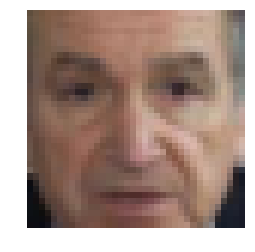

In [3]:
# show a random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")
plt.axis('off');

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And I bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noise for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noise.
* __D__iscriminator - takes a face sample and tries to tell if it's real or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [4]:
import tensorflow as tf

# Plese don't run tensorfow without this config. Without it you'll take the whole memory of the GPU
# and make it unusable by anyone else
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

import keras
from keras.models import Sequential
from keras import layers as L
from functools import partial

Using TensorFlow backend.


Now it's your choise which GAN to build: Jensen-Shannon or Wasserstein.

In addition to the theoretical difference from the lecture, a couple of practical matters:
Jensen-Shannon GAN should learn several times faster, but is more sensitive to mode collapse and
vanishing gradients. Wasserstein GAN doesn't go well in company of batch normalization and ELU activation.

In [5]:
GAN_TYPE = "Wasserstein" #| "Jensen-Shannon"

In [6]:
CODE_SIZE = 256

# Activations experimentally selected. Will most likely work
# for other combinations of activations/architectures
if GAN_TYPE == "Wasserstein":
    generator_activation = keras.activations.relu
elif GAN_TYPE == "Jensen-Shannon":
    generator_activation = keras.activations.elu

num_filters1 = 15
num_filters2 = 15
num_filters3 = 15
num_filters4 = 15
num_filters5 = 3

kern_size = 3
upsamp_size = 2
    
with tf.name_scope("Generator"):
    # Something like 4-5 Deconv layers with an Upsampling would suffice. 
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([CODE_SIZE]))
    generator.add(L.Reshape((1,1,CODE_SIZE)))
    generator.add(L.UpSampling2D(upsamp_size))  
    generator.add(L.Conv2DTranspose(num_filters1,kern_size,activation=generator_activation))
    generator.add(L.Conv2DTranspose(num_filters2,kern_size,activation=generator_activation))
    generator.add(L.UpSampling2D(upsamp_size)) 
    generator.add(L.Conv2DTranspose(num_filters3,kern_size,activation=generator_activation))
    generator.add(L.Conv2DTranspose(num_filters3,kern_size,activation=generator_activation)) 
    generator.add(L.UpSampling2D(upsamp_size)) 
    generator.add(L.Conv2DTranspose(num_filters4,kern_size,activation=generator_activation)) 
    generator.add(L.Conv2DTranspose(num_filters5,kern_size,activation="tanh"))
#     generator.summary()


In [7]:
assert generator.output_shape[1:] == IMG_SHAPE, \
    "generator must output an image of shape %s, but instead it produces %s" % \
        (IMG_SHAPE, generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [8]:
discriminator_activation = partial(keras.activations.relu, alpha=0.3)

In [9]:
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer(IMG_SHAPE))
    discriminator.add(L.Conv2DTranspose(num_filters5,kern_size,activation="tanh"))
    discriminator.add(L.Conv2DTranspose(num_filters4,kern_size,activation=generator_activation)) 
#     discriminator.add(L.UpSampling2D(upsamp_size)) 
    discriminator.add(L.MaxPool2D(pool_size=(2, 2)))
    discriminator.add(L.Conv2DTranspose(num_filters3,kern_size,activation=generator_activation))
    discriminator.add(L.Conv2DTranspose(num_filters3,kern_size,activation=generator_activation))
#     discriminator.add(L.UpSampling2D(upsamp_size))
    discriminator.add(L.MaxPool2D(pool_size=(2, 2)))
    discriminator.add(L.Conv2DTranspose(num_filters3,kern_size,activation=generator_activation))
    discriminator.add(L.Conv2DTranspose(num_filters3,kern_size,activation=generator_activation))
    discriminator.add(L.Flatten())
    discriminator.add(L.Dense(256, activation=discriminator_activation))
    
    
    # You might want to make it roughly the inverse of the generator
    # The next layers expect 1D vector as input, don't forget to Flatten
    if GAN_TYPE == "Wasserstein":
        # Wasserstein discriminator values are unconstrained
        discriminator.add(L.Dense(1, activation=keras.activations.linear))
    elif GAN_TYPE == "Jensen-Shannon":
        # Jensen-Shannon expects probabilities
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Train generator with __adam__ to speed up training. JS discriminator trains with SGD to avoid problems with momentum, Wassershtein usually manages Adam
* More: https://github.com/soumith/ganhacks


In [10]:
def get_tf_dataset(dataset, batch_size):
    """
    Produces an infinite stram of Tensorflow batches from a numpy dataset. The dataset is shuffled every epoch.
    Args:
       dataset: np.array[n_examples, ...]
       batch_size: int, batch size of the results
    Reuturns:
       Tensor, containing the next batch
    """
    shuffler = tf.contrib.data.shuffle_and_repeat(dataset.shape[0])
    suffled_ds = shuffler(tf.data.Dataset.from_tensor_slices(dataset))
    return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

In [11]:
train_batch_size = 100
real_data = get_tf_dataset(data, train_batch_size)

noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, CODE_SIZE], dtype=tf.float32, name="noise")
discriminator_real = discriminator(real_data)
generated_data = generator(noise)
discriminator_generated = discriminator(generated_data)
# print(discriminator_real, discriminator_generated)

In [12]:
if GAN_TYPE == "Wasserstein":
    with tf.name_scope("gradient_loss"):
        alpha = tf.random_uniform(shape=[tf.shape(generated_data)[0], 1, 1, 1], minval=0., maxval=1.)
        interpolates = alpha*real_data + ((1.-alpha)*generated_data)
        disc_interpolates = discriminator(interpolates)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.))
    EMD_loss = - tf.reduce_mean(discriminator_real) + tf.reduce_mean(discriminator_generated)
    LAMBDA = 10.
    discriminator_loss = EMD_loss + LAMBDA*gradient_penalty

In [13]:
if GAN_TYPE == "Jensen-Shannon":
    logp_real = discriminator(real_data)
    logp_gen = discriminator(generated_data)
#     discriminator_loss = #### Not using this yet

In [14]:
# The values below are rough suggestions aimed at not exploding
disc_learning_rate = 1e-3

if GAN_TYPE == "Wasserstein":
    # https://arxiv.org/pdf/1704.00028.pdf recommends Adam with beta1=0, beta2=0.9
    disc_optimizer = tf.train.AdamOptimizer(disc_learning_rate, beta1=0, beta2=0.9).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)
elif GAN_TYPE == "Jensen-Shannon":
#     We recommend plain gradient descent
#     disc_optimizer = <your code here>
    pass

In [15]:
if GAN_TYPE == "Wasserstein":
    generator_loss = - tf.reduce_mean(discriminator_generated)
     # https://arxiv.org/pdf/1704.00028.pdf
    gen_optimizer = tf.train.AdamOptimizer(1e-4, beta1=0, beta2=0.9).minimize(
        generator_loss, var_list=generator.trainable_weights)
elif GAN_TYPE == "Jensen-Shannon":
#     generator_loss = <your code here>
    gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(generator_loss, var_list=generator.trainable_weights)

In [16]:
learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss)
])

images_summary = tf.summary.image("generated_images", generator(noise))

In [17]:
sess.run(tf.global_variables_initializer())

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [18]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images) != 0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE), cmap="gray")
        plt.axis('off')

def sample_probas(bsize):
    fig, ax = plt.subplots()
    ax.set_title('Generated vs real data')
    ax.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),
             label='D(x)', alpha=0.5, normed=True)
    ax.hist(discriminator.predict(generator.predict(sample_noise_batch(bsize))).ravel(),
             label='D(G(z))', alpha=0.5,  normed=True)
    ax.legend(loc='best')
    return fig, ax

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

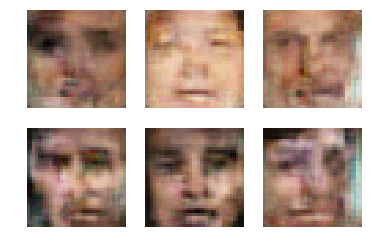

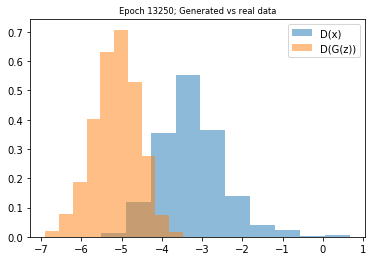

In [ ]:
from IPython import display
import os

LOGDIR = os.path.join("/mnt/students-home", os.environ["USER"], "tensorflow-logs")
MODEL_NAME = "faces_GAN_%s_v2" % GAN_TYPE
MODEL_DIR = os.path.join("/mnt/students-home", os.environ["USER"], "GAN/weights")
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_WEIGHTS_FILE =  os.path.join(MODEL_DIR, ("%s.ckpt" % MODEL_NAME))
VALIDATION_INTERVAL = 50
TOTAL_ITERATIONS = int(5e4)
# Number of discriminator training iterations per generator iteration
# In our tests for discriminator of roughly as complexity as discriminator
# 5 worked for both Wasserstein and Jensen–Shannon.
DISCRIMINATOR_ITERAIONS = 5

train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
train_writer.add_graph(tf.get_default_graph())
weights_saver = tf.train.Saver()
print(weights_saver)

try:
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
except (tf.errors.NotFoundError, tf.errors.InvalidArgumentError):
    print("Can't restore parameters: no file with weights")

for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERAIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _ = sess.run([learning_summary, gen_optimizer], {noise_batch_size: train_batch_size})
    train_writer.add_summary(summary, epoch)
    
    if epoch % VALIDATION_INTERVAL == 0:
        display.clear_output(wait=False)
        weights_saver.save(sess, MODEL_WEIGHTS_FILE)
        epoch_images_summary = sess.run(images_summary, {noise_batch_size: 3})
        train_writer.add_summary(epoch_images_summary, epoch)
        sample_images(2, 3, True)
        fig, ax = sample_probas(1000)
        ax.set_title(("Epoch %i; " % epoch) + ax.get_title())
        plt.show()

In [ ]:
# Training for longer yields MUCH better results
plt.figure(figsize=[16, 24])
sample_images(16, 8);